In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
import os
from fastai.vision.all import *
from nbdev.showdoc import *
import fastbook
fastbook.setup_book()
import random
from fastai.vision.augment import aug_transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from fastai.data.load import DataLoader
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

2024-05-27 17:53:38.097636: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 17:53:38.159441: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 17:53:39.790324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
class RocAuc(Metric):
    def __init__(self): self.reset()
    def reset(self): self.y_pred, self.y_true = [], []
    def accumulate(self, learn):
        pred = learn.pred.detach().cpu()
        targ = learn.y.detach().cpu()
        self.y_pred.append(pred)
        self.y_true.append(targ)
    @property
    def value(self):
        y_pred = torch.cat(self.y_pred).softmax(dim=1)[:,1].numpy()
        y_true = torch.cat(self.y_true).numpy()
        return roc_auc_score(y_true, y_pred)
    @property
    def name(self): return "roc_auc_score"

In [5]:
bac_minus_folder = 'NEGATIVOS'
bac_plus_folder = 'POSITIVOS'

bac_minus_paths = get_image_files(bac_minus_folder)
bac_plus_paths = get_image_files(bac_plus_folder)

bac_minus_labels = [0] * len(bac_minus_paths)
bac_plus_labels = [1] * len(bac_plus_paths)

# Undersampling
np.random.seed(42)
undersampled_bac_minus_paths = np.random.choice(bac_minus_paths, size=len(bac_plus_paths), replace=False)
undersampled_bac_minus_labels = [0] * len(undersampled_bac_minus_paths)

# Combinar paths y labels
all_paths = list(undersampled_bac_minus_paths) + list(bac_plus_paths)
all_labels = undersampled_bac_minus_labels + bac_plus_labels

# Dividir en conjunto de entrenamiento y validación
train_paths, valid_paths, train_labels, valid_labels = train_test_split(all_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

# Crear DataFrame
train_df = pd.DataFrame({'image_path': train_paths, 'label': train_labels})
valid_df = pd.DataFrame({'image_path': valid_paths, 'label': valid_labels})

# Verificar columnas del DataFrame
print(train_df.head())
print(valid_df.head())

                                                                   image_path  \
0   POSITIVOS/DXm.1.2.392.200036.9125.4.0.1344487011.1610668488.80876075.jpeg   
1   POSITIVOS/DXm.1.2.392.200036.9125.4.0.136671738.1694882248.148003828.jpeg   
2   POSITIVOS/DXm.1.2.392.200036.9125.4.0.1327708945.922802632.148003828.jpeg   
3  POSITIVOS/DXm.1.2.392.200036.9125.4.0.1143184573.2130893256.148003828.jpeg   
4          NEGATIVOS/DXm.1.2.840.113681.2206990683.717.3654314566.9894.1.jpeg   

   label  
0      1  
1      1  
2      1  
3      1  
4      0  
                                                                   image_path  \
0  POSITIVOS/DXm.1.2.392.200036.9125.4.0.4230131296.2953107912.148003828.jpeg   
1  NEGATIVOS/DXm.1.2.392.200036.9125.4.0.319783839.4033682688.2020865701.jpeg   
2   POSITIVOS/DXm.1.2.392.200036.9125.4.0.4045568724.369482184.148003828.jpeg   
3  POSITIVOS/DXm.1.2.392.200036.9125.4.0.2569238810.4278311368.148003828.jpeg   
4   NEGATIVOS/DXm.1.2.392.200036.9125.4.0.

In [6]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('image_path'),  # Columna con las rutas de los archivos
    get_y=ColReader('label'),  # Columna con las etiquetas
    splitter=RandomSplitter(seed=42),
    item_tfms=Resize(512),
    batch_tfms=aug_transforms(flip_vert=False, do_flip=False)
)

# Crear DataLoaders
dls = dblock.dataloaders(pd.concat([train_df, valid_df]))

In [7]:
vis_learn = cnn_learner(dls, resnet18, metrics=[accuracy, RocAuc()], pretrained=True)

/data/home/alopezortiz/fastai-master/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [8]:
vis_learn.fine_tune(15, freeze_epochs=15, 
                      cbs=[EarlyStoppingCallback(monitor='accuracy', patience=10), 
                           SaveModelCallback(monitor='accuracy', with_opt=True, fname='fastai2_VIS_0_undersampling')])


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.045276,0.709376,0.674528,0.704075,01:33
1,0.933569,0.826079,0.674528,0.778079,01:27
2,0.864101,0.914203,0.636792,0.766061,01:32
3,0.814433,0.691575,0.655660,0.765700,01:35
4,0.781756,0.584619,0.707547,0.800940,01:28
5,0.749687,0.522913,0.750000,0.837354,01:27
6,0.685491,0.509736,0.754717,0.850095,01:24
7,0.655571,0.544880,0.768868,0.856872,01:31
8,0.626868,0.578745,0.773585,0.848830,01:30
9,0.619092,0.591160,0.754717,0.831752,01:31


Better model found at epoch 0 with accuracy value: 0.6745283007621765.
Better model found at epoch 4 with accuracy value: 0.7075471878051758.
Better model found at epoch 5 with accuracy value: 0.75.
Better model found at epoch 6 with accuracy value: 0.7547169923782349.
Better model found at epoch 7 with accuracy value: 0.7688679099082947.
Better model found at epoch 8 with accuracy value: 0.7735849022865295.
Better model found at epoch 10 with accuracy value: 0.8113207817077637.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.486212,0.446338,0.806604,0.880094,01:29
1,0.460472,0.504249,0.773585,0.862745,01:34
2,0.461081,0.485476,0.778302,0.878739,01:37
3,0.443217,0.508153,0.787736,0.858950,01:31
4,0.451675,0.594323,0.783019,0.849011,01:34
5,0.422664,0.531851,0.787736,0.863016,01:29
6,0.398851,0.461877,0.797170,0.895455,01:28
7,0.377836,0.612670,0.778302,0.869341,01:46
8,0.362395,0.602162,0.797170,0.883166,01:28
9,0.336596,0.555270,0.811321,0.888317,01:25


Better model found at epoch 0 with accuracy value: 0.8066037893295288.
Better model found at epoch 9 with accuracy value: 0.8113207817077637.
Better model found at epoch 10 with accuracy value: 0.8301886916160583.


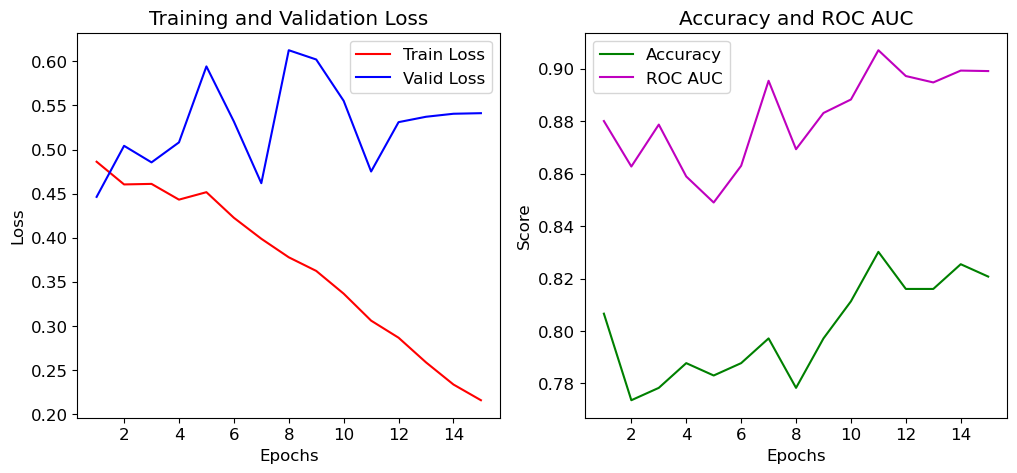

In [9]:
train_losses = [x[0] for x in vis_learn.recorder.values]
valid_losses = [x[1] for x in vis_learn.recorder.values]
accuracies = [x[2] for x in vis_learn.recorder.values]
roc_auc_scores = [x[3] for x in vis_learn.recorder.values]

# Graficar las métricas
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

# Pérdida de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Train Loss')
plt.plot(epochs, valid_losses, 'b', label='Valid Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Precisión y ROC AUC
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'g', label='Accuracy')
plt.plot(epochs, roc_auc_scores, 'm', label='ROC AUC')
plt.title('Accuracy and ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.show()

Predictions shape: torch.Size([212, 2])
Targets shape: torch.Size([212])
Adjusted Targets shape: torch.Size([212])
Confusion Matrix:
[[92 27]
 [ 9 84]]


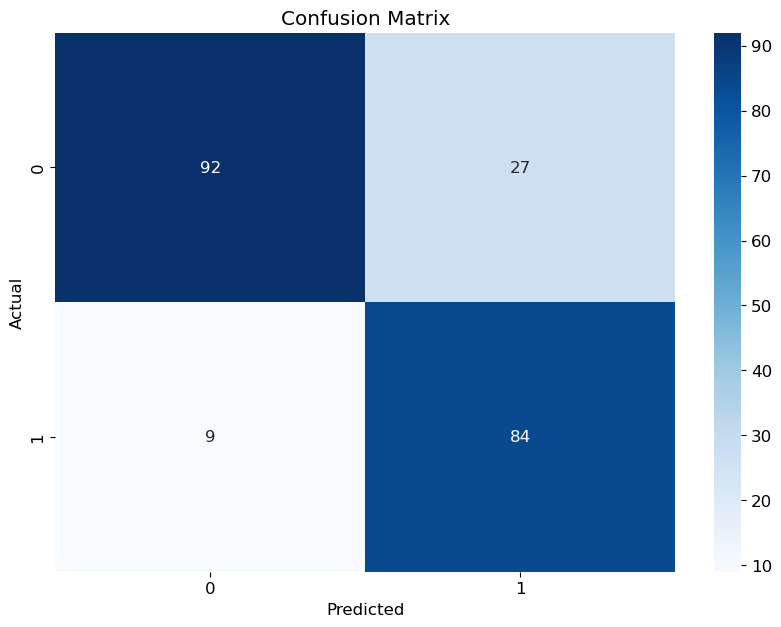

In [10]:
# Confusion Matrix
preds, targs = vis_learn.get_preds()
# Verificar las formas de preds y targs
print(f'Predictions shape: {preds.shape}')
print(f'Targets shape: {targs.shape}')
if len(targs.shape) > 1 and targs.shape[1] == 1:
    targs = targs.squeeze(1)
print(f'Adjusted Targets shape: {targs.shape}')
cm = confusion_matrix(targs, preds.argmax(dim=1))
print('Confusion Matrix:')
print(cm)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dls.vocab, yticklabels=dls.vocab)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

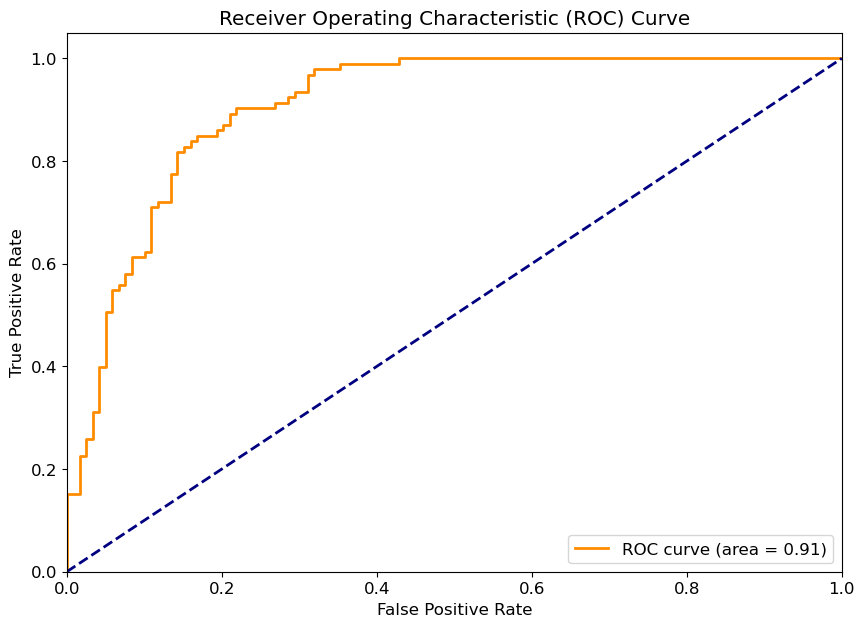

In [11]:
probs = preds[:, 1]
fpr, tpr, _ = roc_curve(targs, probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()